# Detect chessboard

In [1]:
import multicam_calibration as mcc
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np

%matplotlib widget

Saving to /Users/vigji/Desktop/dest_dir/18042024/Calibration/Basler_acA1440-220um__40075240__20240418_180540771_cropped/4_mirror_top.overlay-0-11858.mp4


100%|████████████████████████| 11858/11858 [00:11<00:00, 1003.21frame/s]


Saving to /Users/vigji/Desktop/dest_dir/18042024/Calibration/Basler_acA1440-220um__40075240__20240418_180540771_cropped/3_mirror_right.overlay-0-11858.mp4


100%|████████████████████████| 11858/11858 [00:09<00:00, 1218.16frame/s]


Saving to /Users/vigji/Desktop/dest_dir/18042024/Calibration/Basler_acA1440-220um__40075240__20240418_180540771_cropped/2_mirror_left.overlay-0-11858.mp4


100%|████████████████████████| 11858/11858 [00:09<00:00, 1231.93frame/s]


Saving to /Users/vigji/Desktop/dest_dir/18042024/Calibration/Basler_acA1440-220um__40075240__20240418_180540771_cropped/1_mirror_bottom.overlay-0-11858.mp4


100%|████████████████████████| 11858/11858 [00:09<00:00, 1305.98frame/s]


Saving to /Users/vigji/Desktop/dest_dir/18042024/Calibration/Basler_acA1440-220um__40075240__20240418_180540771_cropped/0_central.overlay-0-11858.mp4


100%|█████████████████████████| 11858/11858 [00:19<00:00, 605.90frame/s]


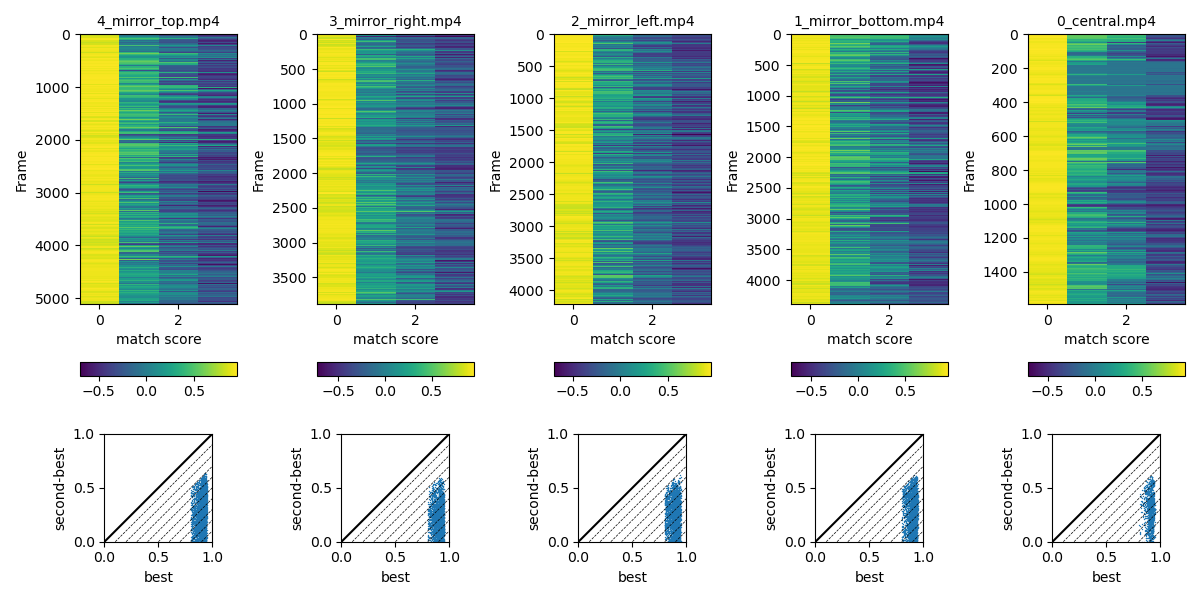

In [66]:
board_shape = (5, 7)
square_size = 12.5

# camera_names = ['top', 'side1', 'side2', 'side3', 'side4', 'bottom']
# prefix = '../../tests/example_data/example_calibration'
data_dir = Path(
    "/Users/vigji/Desktop/dest_dir/18042024"
)  # /Calibration/Basler_acA1440-220um__40075240__20240418_180540771_cropped
video_paths = sorted(
    [f for f in (data_dir.glob("Calibration/*/*.mp4")) if "overlay" not in f.stem]
)[::-1]
camera_names = [p.stem.split("_")[-1].split(".detections")[0] for p in video_paths]

video_paths = [str(f) for f in video_paths]

# detect calibration object in each video
all_calib_uvs, all_img_sizes = mcc.run_calibration_detection(
    video_paths,
    mcc.detect_chessboard,
    n_workers=6,
    detection_options=dict(board_shape=board_shape, scale_factor=0.5),
)

# display a table with the detections shared between camera pairs
mcc.summarize_detections(all_calib_uvs)

# plot corner-match scores for each frame
fig = mcc.plot_chessboard_qc_data(video_paths)

# optionally generate overlay videos
for p in video_paths:
    mcc.overlay_detections(p)
fig.savefig(data_dir / "checkerboard_errors.png")

# Calibrate

In [67]:
import os
import h5py
import flammkuchen as fl

qc_datas = []
for video_path in video_paths:
    detections_path = os.path.splitext(video_path)[0] + ".detections.h5"
    assert os.path.exists(detections_path), (
        f"Could not find {detections_path}. " "Run `run_calibration_detection` first."
    )
    with h5py.File(detections_path, "r") as h5:
        qc_datas.append(h5["qc_data"][:])

## Initialization

In [68]:
calib_objpoints = mcc.generate_chessboard_objpoints(board_shape, square_size)
s = slice(None, None)

all_extrinsics, all_intrinsics, calib_poses, spanning_tree = mcc.calibrate(
    all_calib_uvs[:, s, :, :],
    all_img_sizes,
    calib_objpoints,
    root=0,
    n_samples_for_intrinsics=100,
)
fig.savefig(data_dir / "shared_detections.png")

Estimating camera intrinsics


100%|█████████████████████████████████████| 5/5 [00:12<00:00,  2.53s/it]


Initializing calibration object poses


100%|█████████████████████████████████████| 5/5 [00:02<00:00,  2.20it/s]


Estimating camera extrinsics
Merging calibration object poses


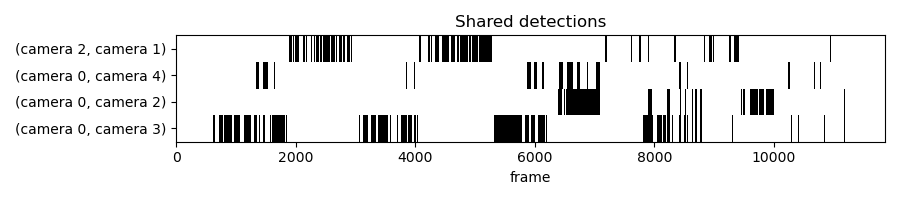

In [69]:
fig, shared_detections = mcc.plot_shared_detections(all_calib_uvs, spanning_tree)

In [70]:
valid = (
    (~np.isnan(all_calib_uvs[1, :, 0, 0])) & (~np.isnan(all_calib_uvs[0, :, 0, 0]))
).astype(int)
np.sum(valid)

914

In [71]:
import tqdm
import cv2

n_cameras, n_frames, N, _ = all_calib_uvs.shape
median_error = np.zeros(n_cameras)
reprojections = np.zeros((n_cameras, n_frames, N, 2))
transformed_reprojections = np.zeros((n_cameras, n_frames, N, 2)) * np.nan
pts = mcc.embed_calib_objpoints(calib_objpoints, calib_poses)

errors_list = []
for cam in tqdm.trange(n_cameras):
    reprojections[cam] = mcc.project_points(
        pts, all_extrinsics[cam], all_intrinsics[cam][0]
    )
    uvs_undistorted = mcc.undistort_points(all_calib_uvs[cam], *all_intrinsics[cam])
    valid_ixs = np.nonzero(~np.isnan(uvs_undistorted).any((-1, -2)))[0]
    for t in valid_ixs:
        H = cv2.findHomography(uvs_undistorted[t], calib_objpoints[:, :2])
        transformed_reprojections[cam, t] = cv2.perspectiveTransform(
            reprojections[cam, t][np.newaxis], H[0]
        )[0]

    errors = np.linalg.norm(
        transformed_reprojections[cam, valid_ixs] - calib_objpoints[:, :2],
        axis=-1,
    )
    median_error[cam] = np.median(errors)
    errors_arr = np.zeros(n_frames) * np.nan
    errors_arr[valid_ixs] = np.median(errors, axis=1)
    errors_list.append(errors_arr)

100%|██████████| 5/5 [00:01<00:00,  3.27it/s]


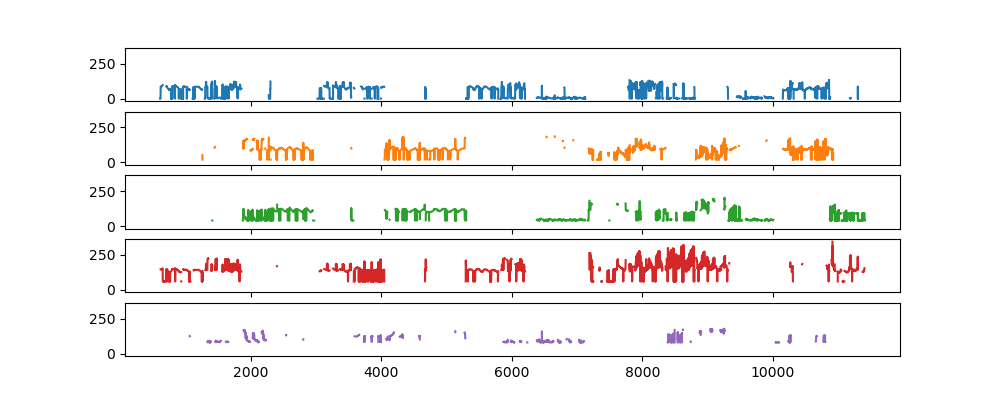

In [72]:
f, axs = plt.subplots(len(errors_list), 1, figsize=(10, 4), sharex=True, sharey=True)

for i, errors in enumerate(errors_list):
    axs[i].plot(errors + i * 20, c=f"C{i}")
# plt.plot(errors_list[0].mean(1))

100%|██████████| 5/5 [00:01<00:00,  3.32it/s]


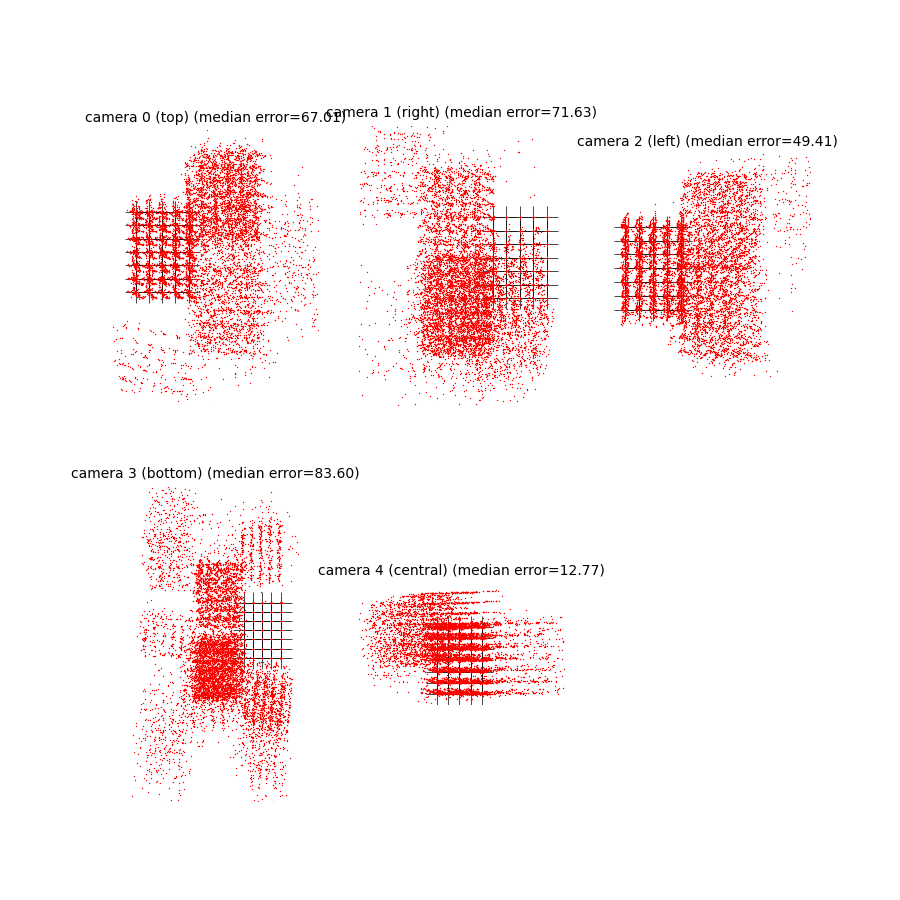

In [73]:
s = slice(0, None)
fig, median_error, reprojections, transformed_reprojections = mcc.plot_residuals(
    all_calib_uvs[:, s, :, :],
    all_extrinsics,
    all_intrinsics,
    calib_objpoints,
    calib_poses[s, :],
    cam_names=camera_names,
    inches_per_axis=3,
)
fig.savefig(data_dir / "first_residuals.png")

## Bundle adjustment

In [74]:
adj_extrinsics, adj_intrinsics, adj_calib_poses, use_frames, result = mcc.bundle_adjust(
    all_calib_uvs,
    all_extrinsics,
    all_intrinsics,
    calib_objpoints,
    calib_poses,
    n_frames=None,
    ftol=1e-4,
)

Excluding 0 out of 8015 frames based on an outlier threshold of 444.294180047836
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.1188e+07                                    1.96e+08    
       1              8         5.7803e+07      3.38e+06       2.70e+04       1.08e+08    
       2              9         5.6141e+07      1.66e+06       1.39e+03       1.09e+08    
       3             10         5.4068e+07      2.07e+06       2.66e+03       9.97e+07    
       4             12         5.3416e+07      6.53e+05       1.04e+03       1.00e+08    
       5             13         5.2251e+07      1.16e+06       9.31e+02       9.98e+07    
       6             14         5.0507e+07      1.74e+06       2.49e+03       1.00e+08    
       7             15         4.8093e+07      2.41e+06       1.39e+03       9.99e+07    
       8             16         4.6152e+07      1.94e+06       9.97e+02       9.99e+07    
       9 

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:01<00:00,  3.57it/s]


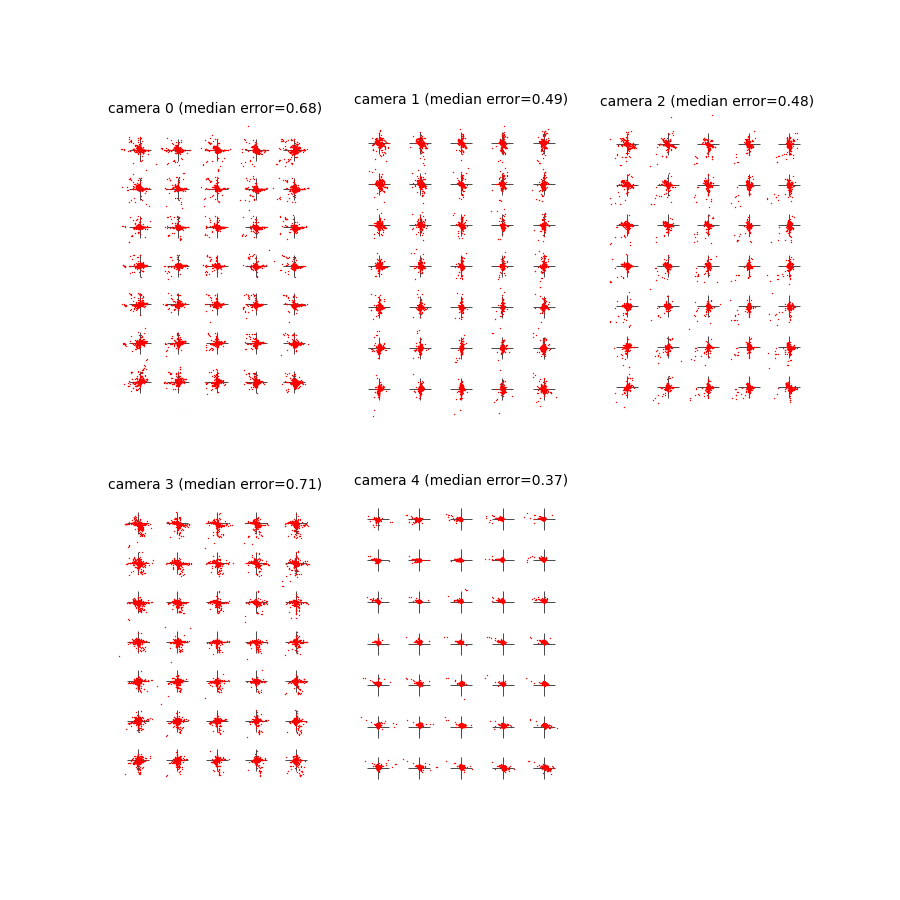

In [76]:
fig, median_error, reprojections, transformed_reprojections = mcc.plot_residuals(
    all_calib_uvs[:, use_frames],
    adj_extrinsics,
    adj_intrinsics,
    calib_objpoints,
    adj_calib_poses,
    inches_per_axis=3,
)
fig.savefig(data_dir / "refined_residuals.png")

In [77]:
len(use_frames)

8015

In [16]:
adj_extrinsics, adj_intrinsics, adj_calib_poses, use_frames, result = mcc.bundle_adjust(
    all_calib_uvs,
    adj_calib_poses,
    adj_intrinsics,
    calib_objpoints,
    adj_calib_poses,
    n_frames=5000,
    ftol=1e-4,
)

IndexError: index 5000 is out of bounds for axis 0 with size 5000

# Save results

In [78]:
# save for JARVIS
video_dir = data_dir / "calibration_vals"
save_path = f"{video_dir}/CalibrationParameters/"
mcc.save_calibration(
    all_extrinsics, all_intrinsics, camera_names, save_path, save_format="jarvis"
)

# save for GIMBAL
save_path = f"{video_dir}/camera_params.h5"
mcc.save_calibration(
    all_extrinsics, all_intrinsics, camera_names, save_path, save_format="gimbal"
)
# save for GIMBAL
save_path = f"{video_dir}/camera_params_adj.h5"
mcc.save_calibration(
    adj_extrinsics, adj_intrinsics, camera_names, save_path, save_format="gimbal"
)

## Triangulate

In [86]:
import flammkuchen as fl

adj_extrinsics_loaded, adj_intrinsics_loaded, camera_names = mcc.load_calibration(
    save_path, load_format="gimbal"
)

In [49]:
all_triang = []
for i in tqdm.tqdm(range(35)):
    all_triang.append(
        mcc.triangulate(all_calib_uvs[:, :, i, :], all_extrinsics, all_intrinsics)
    )
all_triang = np.array(all_triang)

100%|██████████| 35/35 [00:33<00:00,  1.06it/s]


In [87]:
all_calib_uvs.shape

(5, 11858, 35, 2)

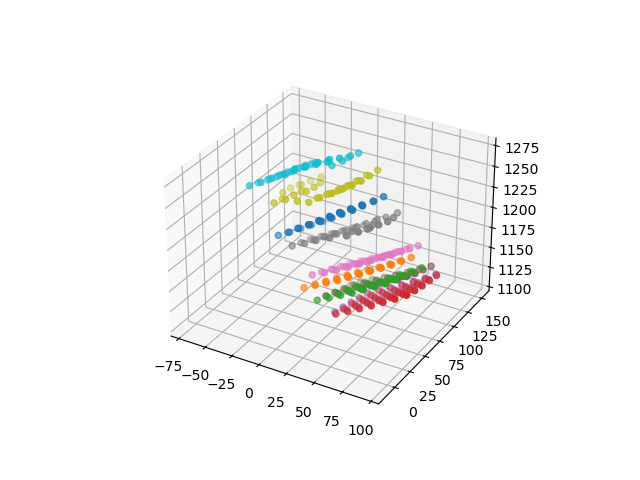

In [57]:
def set_axes_equal(ax):
    """
    Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    """

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5 * max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])


fig = plt.figure()
ax = fig.add_subplot(projection="3d")
for i in range(10):
    off = 8000 + i * 10
    ax.scatter(all_triang[:, off, 0], all_triang[:, off, 1], all_triang[:, off, 2])
# ax.scatter(all_triang[:, ::100, 0].flatten(),
#            all_triang[:, ::100, 1].flatten(),
#            all_triang[:, ::100, 2].flatten() )
set_axes_equal(ax)

NameError: name 'set_axes_equal' is not defined